# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


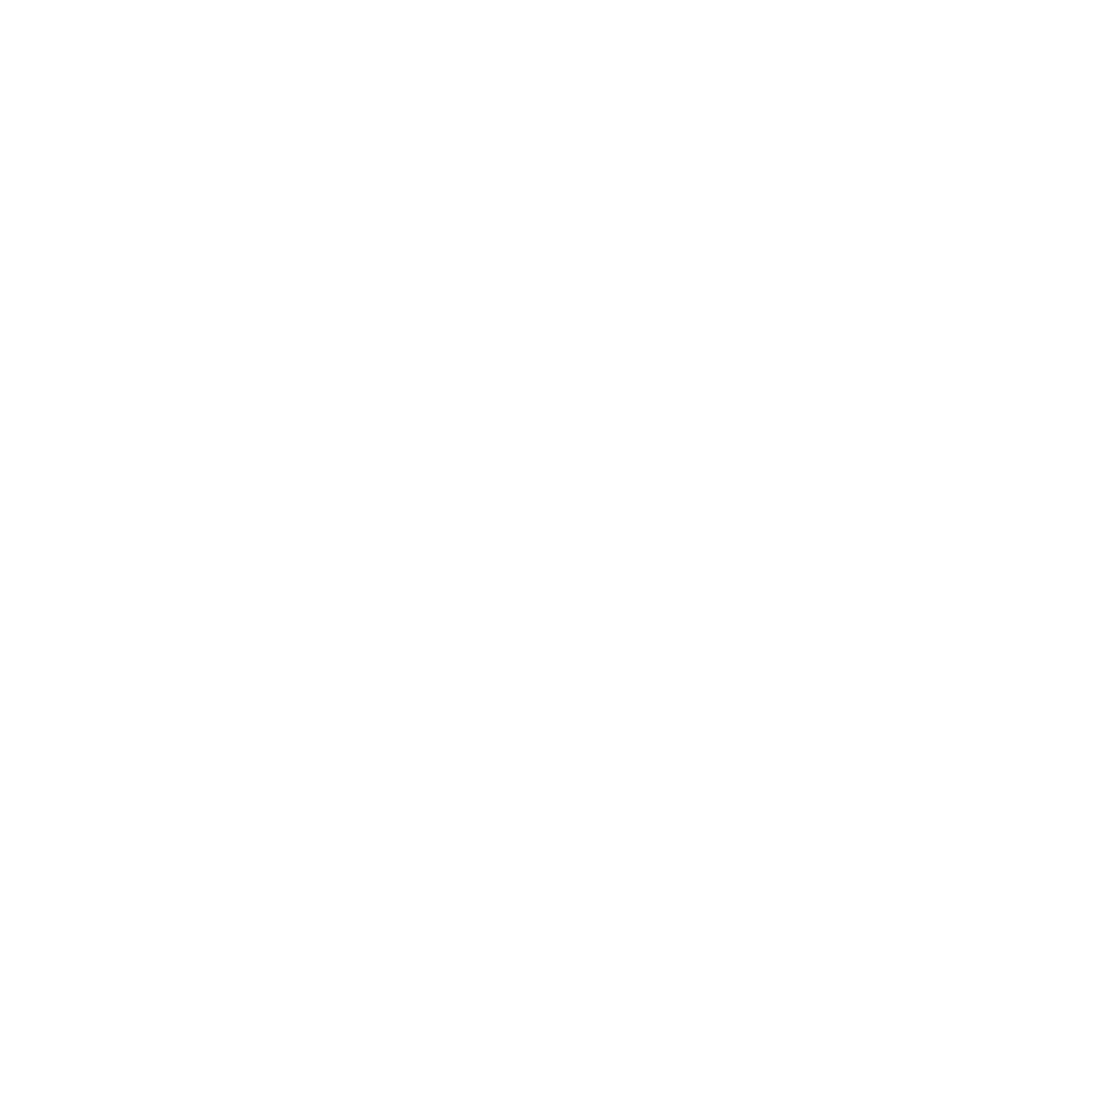

In [267]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [268]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

def loginfo(msg):
    print(str(dt.datetime.now()) + " - " + str(msg))
starttime = dt.datetime.now()

loginfo("Loading dataset...")
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df['Date'] = pd.to_datetime(df['Date'])
loginfo(str(len(df)) + ' rows loaded')

# remove leap days
def isLeapDay(dt):
    return (dt.day == 29) & (dt.month == 2)
df=df[~df['Date'].apply(isLeapDay)]

# initial temperatures are in tenth of degrees Celsius: convert them to degrees
df['Data_Value'] = 0.1* df['Data_Value']
loginfo(str(len(df)) + ' rows after removing leap days')

# util function to filter and group the dataframe by day
def getTemperaturesGroupedByElement(dataframe, elementName):
    return dataframe[(dataframe['Element']==elementName)].groupby(['Date2015'])['Data_Value']

loginfo("Get min/max temperatures by day between 2005 and 2014...")
df_2005_2014 = df[(df['Date']>='2005-01-01') & (df['Date']<='2014-12-31')]

#df_2005_2014['Date2015'] = df['Date'].apply(lambda x: pd.to_datetime(dt.date(2015,x.month,x.day)))
# above is too slow (30 seconds for 160k lines); replacing by the below:
df_2005_2014['Date2015'] = pd.to_datetime(20150000+df_2005_2014.Date.dt.month*100+df_2005_2014.Date.dt.day,format='%Y%m%d')

loginfo("Group temperatures by day...")
mintemp = getTemperaturesGroupedByElement(df_2005_2014, 'TMIN').min()
maxtemp = getTemperaturesGroupedByElement(df_2005_2014, 'TMAX').max()

loginfo("Get min/max temperatures by day in 2015...")
df_2015 = df[(df['Date']>='2015-01-01') & (df['Date']<='2015-12-31')]
df_2015 = df_2015.rename(index=str, columns={"Date":"Date2015"})
mintemp2015 = getTemperaturesGroupedByElement(df_2015, 'TMIN').min()
maxtemp2015 = getTemperaturesGroupedByElement(df_2015, 'TMAX').max()

loginfo("Get broken records in 2015...")
minmerged = pd.merge(
    mintemp.reset_index().rename(index=str, columns={"Data_Value":"Data_Value2014"}), 
    mintemp2015.reset_index().rename(index=str, columns={"Data_Value":"Data_Value2015"}), 
    on='Date2015', how='left')
minmerged['isBrokenRecord'] = minmerged['Data_Value2015']<minmerged['Data_Value2014']
minmerged = minmerged[minmerged['isBrokenRecord']==True][['Date2015','Data_Value2015']]
minseries = minmerged.groupby('Date2015').min()

maxmerged = pd.merge(
    maxtemp.reset_index().rename(index=str, columns={"Data_Value":"Data_Value2014"}), 
    maxtemp2015.reset_index().rename(index=str, columns={"Data_Value":"Data_Value2015"}), 
    on='Date2015', how='left')
maxmerged['isBrokenRecord'] = maxmerged['Data_Value2015']>maxmerged['Data_Value2014']
maxmerged = maxmerged[maxmerged['isBrokenRecord']==True][['Date2015','Data_Value2015']]
maxseries = maxmerged.groupby('Date2015').max()

endtime = dt.datetime.now()
loginfo("Data loaded and pre processed successfully in " + str(endtime - starttime) + "s")

2017-10-22 21:05:31.300546 - Loading dataset...
2017-10-22 21:05:31.490091 - 165085 rows loaded
2017-10-22 21:05:33.024044 - 165002 rows after removing leap days
2017-10-22 21:05:33.024323 - Get min/max temperatures by day between 2005 and 2014...
2017-10-22 21:05:33.325107 - Group temperatures by day...
2017-10-22 21:05:33.377739 - Get min/max temperatures by day in 2015...
2017-10-22 21:05:33.431363 - Get broken records in 2015...
2017-10-22 21:05:33.463072 - Data loaded and pre processed successfully in 0:00:02.162498s


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


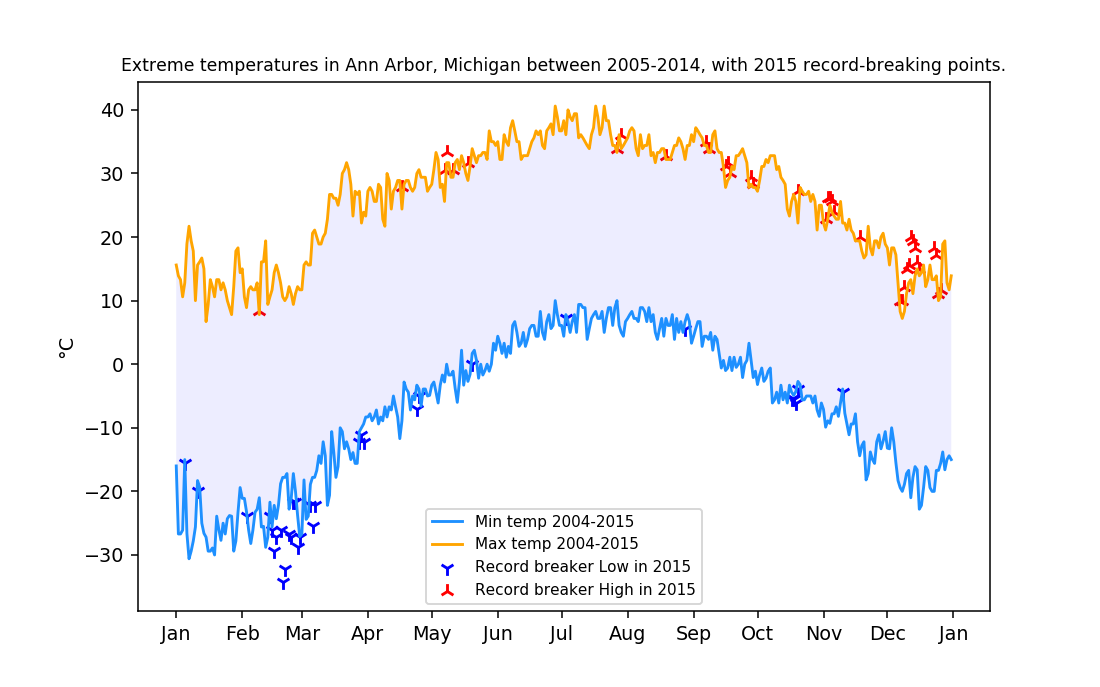

In [269]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig = plt.figure()
plt.rcParams["figure.figsize"] = [8,5] #change plot size
plt.plot(mintemp, 'dodgerblue', label='Min temp 2004-2015')
plt.plot(maxtemp, 'orange', label='Max temp 2004-2015')
plt.scatter(minseries.index, minseries.values, s=60, c='b', marker = "1", label='Record breaker Low in 2015')
plt.scatter(maxseries.index, maxseries.values, s=60, c='r', marker = "2", label='Record breaker High in 2015')

plt.ylabel('°C')
plt.title('Extreme temperatures in Ann Arbor, Michigan between 2005-2014, with 2015 record-breaking points.', fontsize=9)

# fill the area between min and max temperatures
ax = plt.gca()
ax.fill_between(mintemp.index, mintemp, maxtemp, facecolor='blue', alpha=0.07)

# format x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# add a legend (uses the labels from plt.scatter)
plt.legend(loc=8, frameon=True, fontsize=8)